In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import gpytorch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
import GaussianProcess

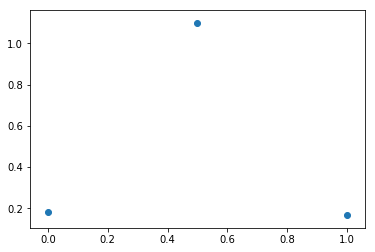

In [3]:
#generates data

num_datapoints = 3

def f(x):
    return np.sin(3*x)

xs = torch.linspace(0, 1, num_datapoints)
ys = f(xs) + torch.distributions.Normal(torch.zeros(num_datapoints), .1).rsample()
plt.scatter(xs, ys)

In [126]:
y_var = 0.1

class encoder(nn.Module):
    def __init__(self, y_size, x_size, hidden_layer_size, encoded_size):
        super(encoder, self).__init__()
        self.fc1 = nn.Linear(y_size + x_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3_mu = nn.Linear(hidden_layer_size, encoded_size)
        self.fc3_logvar = nn.Linear(hidden_layer_size, encoded_size**2)
        self.relu = nn.LeakyReLU()
        
    def forward(self, y):
        l1 = self.relu(self.fc1(y))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3_mu(l2)
        sigma = self.fc3_logvar(l2).mul(1/2).exp()
        return mu, sigma
    
def z_dist(mu, sigma, x_size, y_size, encoded_size):
    sigma = sigma.reshape(encoded_size, encoded_size)
    normal = torch.distributions.MultivariateNormal(loc = mu, covariance_matrix = sigma + torch.eye(encoded_size))
    return normal

def z_dist_single_v(mu, sigma , x_size, y_size, encoded_size):
    #sigma = sigma.reshape(encoded_size, encoded_size)
    normal = torch.distributions.Normal(mu, sigma)
    return normal
    
    
class decoder(nn.Module):
    def __init__(self, encoded_size, y_size, hidden_layer_size):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(encoded_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, y_size)
        self.relu = nn.LeakyReLU()
        
    def forward(self, z):
        l1 = self.relu(self.fc1(z))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3(l2)
        return mu
    
def get_y(mu):
    normal = torch.distributions.Normal(mu, y_var)
    return normal

class RegressionVAE(nn.Module):
    def __init__(self, x_size, y_size, hidden_layer_size, encoded_size, likelihood, xs, ys):
        super(RegressionVAE, self).__init__()
        self.enc = encoder(y_size, x_size, hidden_layer_size, encoded_size)
        self.dec = decoder(encoded_size, y_size, hidden_layer_size)
        self.xs = xs
        self.ys = ys
        self.x_size = x_size
        self.y_size = y_size
        self.encoded_size = encoded_size
        self.likelihood = likelihood
        self.regressor = None
        self.zs = []
        
    def get_zs(self):
        zs = []
        for i in range(len(self.xs)):
            x = Variable(torch.tensor([self.xs[i]]).type('torch.FloatTensor'))
            y = Variable(torch.tensor([self.ys[i]])).type('torch.FloatTensor')
            xy = torch.cat([x, y])
            mu, _ = self.enc(xy)
            zs.append(mu.double())
        self.zs = torch.cat(zs).reshape(self.encoded_size, len(self.xs))[0].type('torch.FloatTensor')

    def train_regressor(self):
        self.regressor = GaussianProcess.ExactGPModel(self.xs, self.zs, self.likelihood)
        GaussianProcess.train_gp(self.regressor, self.likelihood, self.xs, self.zs)
    
    def forward(self, x):
        self.regressor.eval()
        z = self.regressor(x)
        zsample = z.mean
        zstddev = z.stddev
        ymu = self.dec(zsample)
        y_upper = self.dec(zsample + zstddev)
        y_lower = self.dec(zsample - zstddev)
        return ymu, y_upper, y_lower
    
    def plot(self):
        X = torch.linspace(0, 1, 100)
        mus = []
        uppers = []
        lowers = []
        for x in X:
            mu, upper, lower = self.forward(torch.tensor([x]))
            mus.append(mu.detach().numpy())
            uppers.append(upper.detach().numpy())
            lowers.append(lower.detach().numpy())
        mu, uppers, lowers = np.array(mus), np.array(uppers), np.array(lowers)
        plt.plot(X.detach().numpy(), mus, c = 'b')
        plt.plot(X.detach().numpy(), uppers, c = 'grey')
        plt.plot(X.detach().numpy(), lowers, c = 'grey')
        plt.scatter(self.xs.detach().numpy(), self.ys.detach().numpy())
        
    def plot_zs(self):
        GaussianProcess.plot_gp(self.regressor, self.likelihood, self.xs.detach(), self.zs.detach())
        
    def forward_infoVAE(self, alpha, ld):    
        y = self.ys
        x = self.xs
        zmu, zsigma = self.enc(torch.cat([x, y]).reshape(self.x_size+self.y_size, len(self.xs)).transpose(0,1))
        z_posterior = z_dist_single_v(zmu, zsigma, 1, 1, 1)
        
        
        def prob_of_y(z):
            dist_mu = self.dec(z)
            dist = torch.distributions.Normal(dist_mu, y_var)
            return dist.log_prob(y).sum()
        
        
        mu = z_posterior.mean
        sigma = z_posterior.stddev
        
        expectation_log_likelihood = montecarlo_expectation(z_posterior, prob_of_y, 10)
        kl_1 =  -0.5*torch.sum(1 + sigma - mu.pow(2) - sigma.pow(2), dim=0)
        
        
        self.get_zs()
        self.train_regressor()
        kl_2 = 0
        for i in range(len(x)):
            regressed_ys_mus, _, _ = self.forward(torch.tensor([x[i]]))
            regressed_ys_dist = torch.distributions.Normal(regressed_ys_mus, y_var)
        
            r_mu = regressed_ys_dist.mean
            r_dev = regressed_ys_dist.stddev
            kl_2 += -0.5*torch.sum(1 + r_dev - r_mu.pow(2) - r_dev.pow(2), dim=0)
            
        
        loss = -expectation_log_likelihood - (1-alpha)*kl_1 - (alpha + ld - 1)*kl_2
        return loss
        
def lossf(newy, oldy, normal):
    #KLD = -0.5*torch.sum(1 + normal.stddev - normal.mean.pow(2) - normal.stddev.pow(2), dim=0)
    return (newy - oldy)**2 #+ KLD

def lossf1(y_dist, z_dist, target_y, alpha):
    normal = torch.distributions.Normal(torch.zeros(target_y.size()), 1.)
    sigma_2 = z_dist.variance
    mu_2 = z_dist.mean
    
    KLD = -0.5*torch.sum(1 + sigma_2 - mu_2.pow(2) - sigma_2.pow(2), dim=0)
    log_like = y_dist.log_prob(target_y)
    return - alpha*log_like + (1-alpha)*KLD
        
def train(vae, epochs, alpha, optimizer):
    vae.train()
    for epoch in range(epochs):
        error = 0
        for i in range(len(vae.xs)):
            optimizer.zero_grad()
            x = Variable(torch.tensor([vae.xs[i]]).type('torch.FloatTensor'))
            y = Variable(torch.tensor([vae.ys[i]]).type('torch.FloatTensor'))
            xy = torch.cat([x, y])
            mu, sigma = vae.enc(xy)
            normal = z_dist(mu, sigma, vae.x_size, vae.y_size, vae.encoded_size)
            zsample = normal.rsample()
            mu = vae.dec(zsample)
            y_new_dist = get_y(mu)
            y_new = y_new_dist.rsample()
            loss = lossf1(y_new_dist, normal, ys[i], alpha)
            error += loss
            loss.backward()
            optimizer.step()
        if epoch % 500 == 0:
            print('EPOCH {}, LOSS {}'.format(epoch, error))
            vae.get_zs()
            vae.train_regressor()
            vae.plot()
            plt.show()
            plt.savefig('epoch{}alpha{}.png'.format(epoch, alpha))
            
def train_infoVAE(vae, epochs, alpha, ld, optimizer):
    vae.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = vae.forward_infoVAE(alpha, ld)
        loss.backward()
        optimizer.step()
        print('EPOCH: {}'.format(epoch))
        if epoch % 50 == 0:
            print('EPOCH {}, LOSS {}'.format(epoch, loss))
            vae.get_zs()
            vae.train_regressor()
            vae.plot()
            plt.show()
            plt.savefig('epoch{}alpha{}.png'.format(epoch, alpha))
            
def montecarlo_expectation(normal, f, iterations):
    mu = 0
    for i in range(iterations):
        mu += f(normal.rsample())
    mu = mu/iterations
    return mu

In [127]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())

EPOCH: 0
EPOCH 0, LOSS tensor([83.4624], grad_fn=<SubBackward0>)


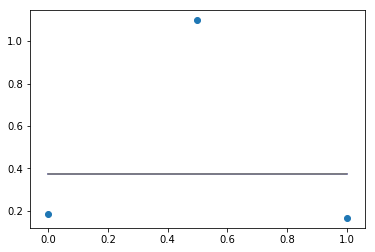

EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4
EPOCH: 5
EPOCH: 6
EPOCH: 7
EPOCH: 8
EPOCH: 9
EPOCH: 10
EPOCH: 11
EPOCH: 12
EPOCH: 13
EPOCH: 14
EPOCH: 15
EPOCH: 16
EPOCH: 17
EPOCH: 18
EPOCH: 19
EPOCH: 20
EPOCH: 21
EPOCH: 22
EPOCH: 23
EPOCH: 24
EPOCH: 25
EPOCH: 26
EPOCH: 27
EPOCH: 28
EPOCH: 29
EPOCH: 30
EPOCH: 31
EPOCH: 32
EPOCH: 33
EPOCH: 34
EPOCH: 35
EPOCH: 36
EPOCH: 37
EPOCH: 38
EPOCH: 39
EPOCH: 40
EPOCH: 41
EPOCH: 42
EPOCH: 43
EPOCH: 44
EPOCH: 45
EPOCH: 46
EPOCH: 47
EPOCH: 48
EPOCH: 49
EPOCH: 50
EPOCH 50, LOSS tensor([74.1756], grad_fn=<SubBackward0>)


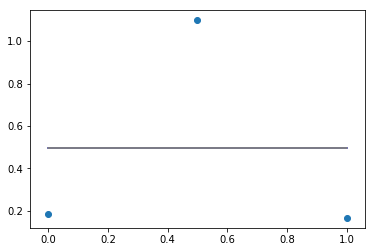

EPOCH: 51
EPOCH: 52
EPOCH: 53
EPOCH: 54
EPOCH: 55
EPOCH: 56
EPOCH: 57
EPOCH: 58
EPOCH: 59
EPOCH: 60
EPOCH: 61
EPOCH: 62
EPOCH: 63
EPOCH: 64
EPOCH: 65
EPOCH: 66
EPOCH: 67
EPOCH: 68
EPOCH: 69
EPOCH: 70
EPOCH: 71
EPOCH: 72
EPOCH: 73
EPOCH: 74
EPOCH: 75
EPOCH: 76
EPOCH: 77
EPOCH: 78
EPOCH: 79
EPOCH: 80
EPOCH: 81
EPOCH: 82
EPOCH: 83
EPOCH: 84
EPOCH: 85
EPOCH: 86
EPOCH: 87
EPOCH: 88
EPOCH: 89
EPOCH: 90
EPOCH: 91
EPOCH: 92
EPOCH: 93
EPOCH: 94
EPOCH: 95
EPOCH: 96
EPOCH: 97
EPOCH: 98
EPOCH: 99
EPOCH: 100
EPOCH 100, LOSS tensor([74.0947], grad_fn=<SubBackward0>)


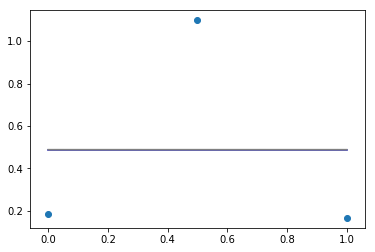

EPOCH: 101
EPOCH: 102
EPOCH: 103
EPOCH: 104
EPOCH: 105
EPOCH: 106
EPOCH: 107
EPOCH: 108
EPOCH: 109
EPOCH: 110
EPOCH: 111
EPOCH: 112
EPOCH: 113
EPOCH: 114
EPOCH: 115
EPOCH: 116
EPOCH: 117
EPOCH: 118
EPOCH: 119
EPOCH: 120
EPOCH: 121
EPOCH: 122
EPOCH: 123
EPOCH: 124
EPOCH: 125
EPOCH: 126
EPOCH: 127
EPOCH: 128
EPOCH: 129
EPOCH: 130
EPOCH: 131
EPOCH: 132
EPOCH: 133
EPOCH: 134
EPOCH: 135
EPOCH: 136
EPOCH: 137
EPOCH: 138
EPOCH: 139
EPOCH: 140
EPOCH: 141
EPOCH: 142
EPOCH: 143
EPOCH: 144
EPOCH: 145
EPOCH: 146
EPOCH: 147
EPOCH: 148
EPOCH: 149
EPOCH: 150
EPOCH 150, LOSS tensor([74.0778], grad_fn=<SubBackward0>)


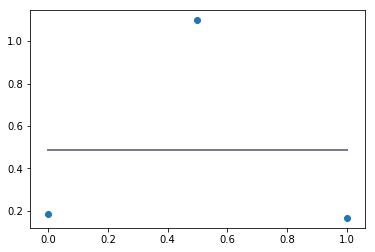

EPOCH: 151
EPOCH: 152
EPOCH: 153
EPOCH: 154
EPOCH: 155
EPOCH: 156
EPOCH: 157
EPOCH: 158
EPOCH: 159
EPOCH: 160
EPOCH: 161
EPOCH: 162
EPOCH: 163
EPOCH: 164
EPOCH: 165
EPOCH: 166
EPOCH: 167
EPOCH: 168
EPOCH: 169
EPOCH: 170
EPOCH: 171
EPOCH: 172
EPOCH: 173
EPOCH: 174
EPOCH: 175
EPOCH: 176
EPOCH: 177
EPOCH: 178
EPOCH: 179
EPOCH: 180
EPOCH: 181
EPOCH: 182
EPOCH: 183
EPOCH: 184
EPOCH: 185
EPOCH: 186
EPOCH: 187
EPOCH: 188
EPOCH: 189
EPOCH: 190
EPOCH: 191
EPOCH: 192
EPOCH: 193
EPOCH: 194
EPOCH: 195
EPOCH: 196
EPOCH: 197
EPOCH: 198
EPOCH: 199
EPOCH: 200
EPOCH 200, LOSS tensor([74.0760], grad_fn=<SubBackward0>)


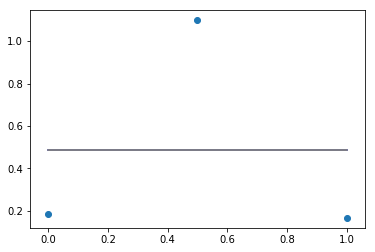

EPOCH: 201
EPOCH: 202
EPOCH: 203
EPOCH: 204
EPOCH: 205
EPOCH: 206
EPOCH: 207
EPOCH: 208
EPOCH: 209
EPOCH: 210
EPOCH: 211
EPOCH: 212
EPOCH: 213
EPOCH: 214
EPOCH: 215
EPOCH: 216
EPOCH: 217
EPOCH: 218
EPOCH: 219
EPOCH: 220
EPOCH: 221
EPOCH: 222
EPOCH: 223
EPOCH: 224
EPOCH: 225
EPOCH: 226
EPOCH: 227
EPOCH: 228
EPOCH: 229
EPOCH: 230
EPOCH: 231
EPOCH: 232
EPOCH: 233
EPOCH: 234
EPOCH: 235
EPOCH: 236
EPOCH: 237
EPOCH: 238
EPOCH: 239
EPOCH: 240
EPOCH: 241
EPOCH: 242
EPOCH: 243
EPOCH: 244
EPOCH: 245
EPOCH: 246
EPOCH: 247
EPOCH: 248
EPOCH: 249
EPOCH: 250
EPOCH 250, LOSS tensor([74.0758], grad_fn=<SubBackward0>)


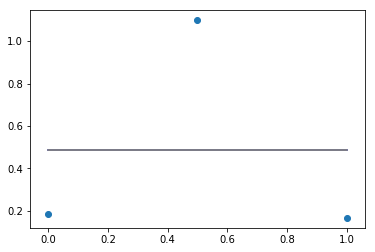

EPOCH: 251
EPOCH: 252
EPOCH: 253
EPOCH: 254
EPOCH: 255
EPOCH: 256
EPOCH: 257
EPOCH: 258
EPOCH: 259
EPOCH: 260
EPOCH: 261
EPOCH: 262
EPOCH: 263
EPOCH: 264
EPOCH: 265
EPOCH: 266
EPOCH: 267
EPOCH: 268
EPOCH: 269
EPOCH: 270
EPOCH: 271
EPOCH: 272
EPOCH: 273
EPOCH: 274
EPOCH: 275
EPOCH: 276
EPOCH: 277
EPOCH: 278
EPOCH: 279
EPOCH: 280
EPOCH: 281
EPOCH: 282
EPOCH: 283
EPOCH: 284
EPOCH: 285
EPOCH: 286
EPOCH: 287
EPOCH: 288
EPOCH: 289
EPOCH: 290
EPOCH: 291
EPOCH: 292
EPOCH: 293
EPOCH: 294
EPOCH: 295
EPOCH: 296
EPOCH: 297
EPOCH: 298
EPOCH: 299
EPOCH: 300
EPOCH 300, LOSS tensor([74.0733], grad_fn=<SubBackward0>)


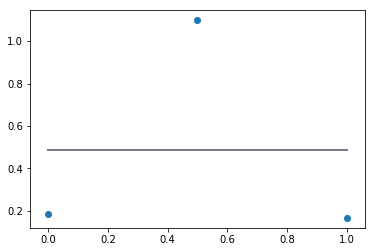

EPOCH: 301
EPOCH: 302
EPOCH: 303
EPOCH: 304
EPOCH: 305
EPOCH: 306
EPOCH: 307
EPOCH: 308
EPOCH: 309
EPOCH: 310
EPOCH: 311
EPOCH: 312
EPOCH: 313
EPOCH: 314
EPOCH: 315
EPOCH: 316
EPOCH: 317
EPOCH: 318
EPOCH: 319
EPOCH: 320
EPOCH: 321
EPOCH: 322
EPOCH: 323
EPOCH: 324
EPOCH: 325
EPOCH: 326
EPOCH: 327
EPOCH: 328
EPOCH: 329
EPOCH: 330
EPOCH: 331
EPOCH: 332
EPOCH: 333
EPOCH: 334
EPOCH: 335
EPOCH: 336
EPOCH: 337
EPOCH: 338
EPOCH: 339
EPOCH: 340
EPOCH: 341
EPOCH: 342
EPOCH: 343
EPOCH: 344
EPOCH: 345
EPOCH: 346
EPOCH: 347
EPOCH: 348
EPOCH: 349
EPOCH: 350
EPOCH 350, LOSS tensor([74.0742], grad_fn=<SubBackward0>)


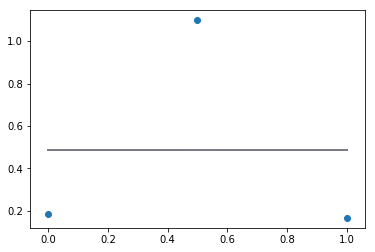

EPOCH: 351
EPOCH: 352
EPOCH: 353
EPOCH: 354
EPOCH: 355
EPOCH: 356
EPOCH: 357
EPOCH: 358
EPOCH: 359
EPOCH: 360
EPOCH: 361
EPOCH: 362
EPOCH: 363
EPOCH: 364
EPOCH: 365
EPOCH: 366
EPOCH: 367
EPOCH: 368
EPOCH: 369
EPOCH: 370
EPOCH: 371
EPOCH: 372
EPOCH: 373
EPOCH: 374
EPOCH: 375
EPOCH: 376
EPOCH: 377
EPOCH: 378
EPOCH: 379
EPOCH: 380
EPOCH: 381
EPOCH: 382
EPOCH: 383
EPOCH: 384
EPOCH: 385
EPOCH: 386
EPOCH: 387
EPOCH: 388
EPOCH: 389
EPOCH: 390
EPOCH: 391
EPOCH: 392
EPOCH: 393
EPOCH: 394
EPOCH: 395
EPOCH: 396
EPOCH: 397
EPOCH: 398
EPOCH: 399
EPOCH: 400
EPOCH 400, LOSS tensor([74.0932], grad_fn=<SubBackward0>)


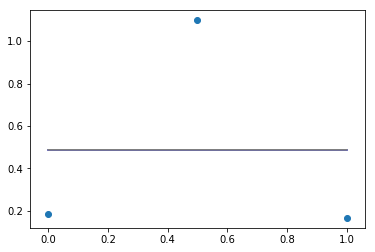

EPOCH: 401
EPOCH: 402
EPOCH: 403
EPOCH: 404
EPOCH: 405
EPOCH: 406
EPOCH: 407
EPOCH: 408
EPOCH: 409
EPOCH: 410
EPOCH: 411
EPOCH: 412
EPOCH: 413
EPOCH: 414
EPOCH: 415
EPOCH: 416
EPOCH: 417
EPOCH: 418
EPOCH: 419
EPOCH: 420
EPOCH: 421
EPOCH: 422
EPOCH: 423
EPOCH: 424
EPOCH: 425
EPOCH: 426
EPOCH: 427
EPOCH: 428
EPOCH: 429
EPOCH: 430
EPOCH: 431
EPOCH: 432
EPOCH: 433
EPOCH: 434
EPOCH: 435
EPOCH: 436
EPOCH: 437
EPOCH: 438
EPOCH: 439
EPOCH: 440
EPOCH: 441
EPOCH: 442
EPOCH: 443
EPOCH: 444
EPOCH: 445
EPOCH: 446
EPOCH: 447
EPOCH: 448
EPOCH: 449
EPOCH: 450
EPOCH 450, LOSS tensor([74.0759], grad_fn=<SubBackward0>)


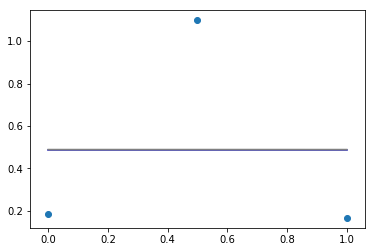

EPOCH: 451
EPOCH: 452
EPOCH: 453
EPOCH: 454
EPOCH: 455
EPOCH: 456
EPOCH: 457
EPOCH: 458
EPOCH: 459
EPOCH: 460
EPOCH: 461
EPOCH: 462
EPOCH: 463
EPOCH: 464
EPOCH: 465
EPOCH: 466
EPOCH: 467
EPOCH: 468
EPOCH: 469
EPOCH: 470
EPOCH: 471
EPOCH: 472
EPOCH: 473
EPOCH: 474
EPOCH: 475
EPOCH: 476
EPOCH: 477
EPOCH: 478
EPOCH: 479
EPOCH: 480
EPOCH: 481
EPOCH: 482
EPOCH: 483
EPOCH: 484
EPOCH: 485
EPOCH: 486
EPOCH: 487
EPOCH: 488
EPOCH: 489
EPOCH: 490
EPOCH: 491
EPOCH: 492
EPOCH: 493
EPOCH: 494
EPOCH: 495
EPOCH: 496
EPOCH: 497
EPOCH: 498
EPOCH: 499
EPOCH: 500
EPOCH 500, LOSS tensor([74.0840], grad_fn=<SubBackward0>)


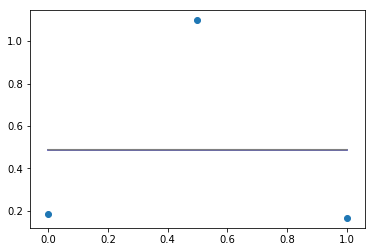

EPOCH: 501
EPOCH: 502
EPOCH: 503
EPOCH: 504
EPOCH: 505
EPOCH: 506
EPOCH: 507
EPOCH: 508
EPOCH: 509
EPOCH: 510
EPOCH: 511
EPOCH: 512
EPOCH: 513
EPOCH: 514
EPOCH: 515
EPOCH: 516
EPOCH: 517
EPOCH: 518
EPOCH: 519
EPOCH: 520
EPOCH: 521
EPOCH: 522
EPOCH: 523
EPOCH: 524
EPOCH: 525
EPOCH: 526
EPOCH: 527
EPOCH: 528
EPOCH: 529
EPOCH: 530
EPOCH: 531
EPOCH: 532
EPOCH: 533
EPOCH: 534
EPOCH: 535
EPOCH: 536
EPOCH: 537
EPOCH: 538
EPOCH: 539
EPOCH: 540
EPOCH: 541
EPOCH: 542
EPOCH: 543
EPOCH: 544
EPOCH: 545
EPOCH: 546
EPOCH: 547
EPOCH: 548
EPOCH: 549
EPOCH: 550
EPOCH 550, LOSS tensor([74.0731], grad_fn=<SubBackward0>)


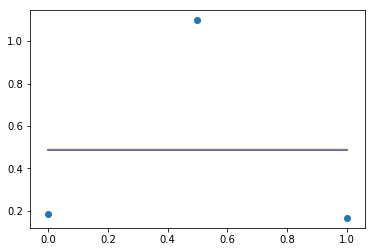

EPOCH: 551
EPOCH: 552
EPOCH: 553
EPOCH: 554
EPOCH: 555
EPOCH: 556
EPOCH: 557
EPOCH: 558
EPOCH: 559
EPOCH: 560
EPOCH: 561
EPOCH: 562
EPOCH: 563
EPOCH: 564
EPOCH: 565
EPOCH: 566
EPOCH: 567
EPOCH: 568
EPOCH: 569
EPOCH: 570
EPOCH: 571
EPOCH: 572
EPOCH: 573
EPOCH: 574
EPOCH: 575
EPOCH: 576
EPOCH: 577
EPOCH: 578
EPOCH: 579
EPOCH: 580
EPOCH: 581
EPOCH: 582
EPOCH: 583
EPOCH: 584
EPOCH: 585
EPOCH: 586
EPOCH: 587
EPOCH: 588
EPOCH: 589
EPOCH: 590
EPOCH: 591
EPOCH: 592
EPOCH: 593
EPOCH: 594
EPOCH: 595
EPOCH: 596
EPOCH: 597
EPOCH: 598
EPOCH: 599
EPOCH: 600
EPOCH 600, LOSS tensor([74.0722], grad_fn=<SubBackward0>)


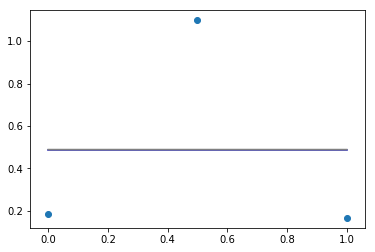

EPOCH: 601
EPOCH: 602
EPOCH: 603
EPOCH: 604
EPOCH: 605
EPOCH: 606
EPOCH: 607
EPOCH: 608
EPOCH: 609
EPOCH: 610
EPOCH: 611
EPOCH: 612
EPOCH: 613
EPOCH: 614
EPOCH: 615
EPOCH: 616
EPOCH: 617
EPOCH: 618
EPOCH: 619
EPOCH: 620
EPOCH: 621
EPOCH: 622
EPOCH: 623
EPOCH: 624
EPOCH: 625
EPOCH: 626
EPOCH: 627
EPOCH: 628
EPOCH: 629
EPOCH: 630
EPOCH: 631
EPOCH: 632
EPOCH: 633
EPOCH: 634
EPOCH: 635
EPOCH: 636
EPOCH: 637
EPOCH: 638
EPOCH: 639
EPOCH: 640
EPOCH: 641
EPOCH: 642
EPOCH: 643
EPOCH: 644
EPOCH: 645
EPOCH: 646
EPOCH: 647
EPOCH: 648
EPOCH: 649
EPOCH: 650
EPOCH 650, LOSS tensor([74.0727], grad_fn=<SubBackward0>)


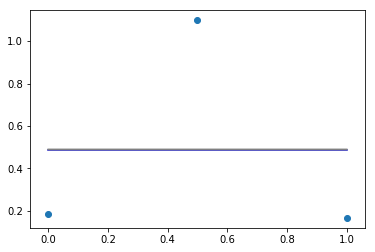

EPOCH: 651
EPOCH: 652
EPOCH: 653
EPOCH: 654
EPOCH: 655
EPOCH: 656
EPOCH: 657
EPOCH: 658
EPOCH: 659
EPOCH: 660
EPOCH: 661
EPOCH: 662
EPOCH: 663
EPOCH: 664
EPOCH: 665
EPOCH: 666
EPOCH: 667
EPOCH: 668
EPOCH: 669
EPOCH: 670
EPOCH: 671
EPOCH: 672
EPOCH: 673
EPOCH: 674
EPOCH: 675
EPOCH: 676
EPOCH: 677
EPOCH: 678
EPOCH: 679
EPOCH: 680
EPOCH: 681
EPOCH: 682
EPOCH: 683
EPOCH: 684
EPOCH: 685
EPOCH: 686
EPOCH: 687
EPOCH: 688
EPOCH: 689
EPOCH: 690
EPOCH: 691
EPOCH: 692
EPOCH: 693
EPOCH: 694
EPOCH: 695
EPOCH: 696
EPOCH: 697
EPOCH: 698
EPOCH: 699
EPOCH: 700
EPOCH 700, LOSS tensor([74.0730], grad_fn=<SubBackward0>)


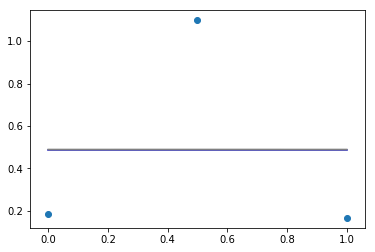

EPOCH: 701
EPOCH: 702
EPOCH: 703
EPOCH: 704
EPOCH: 705
EPOCH: 706
EPOCH: 707
EPOCH: 708
EPOCH: 709
EPOCH: 710
EPOCH: 711
EPOCH: 712
EPOCH: 713
EPOCH: 714
EPOCH: 715
EPOCH: 716
EPOCH: 717
EPOCH: 718
EPOCH: 719
EPOCH: 720
EPOCH: 721
EPOCH: 722
EPOCH: 723
EPOCH: 724
EPOCH: 725
EPOCH: 726
EPOCH: 727
EPOCH: 728
EPOCH: 729
EPOCH: 730
EPOCH: 731
EPOCH: 732
EPOCH: 733
EPOCH: 734
EPOCH: 735
EPOCH: 736
EPOCH: 737
EPOCH: 738
EPOCH: 739
EPOCH: 740
EPOCH: 741
EPOCH: 742
EPOCH: 743
EPOCH: 744
EPOCH: 745
EPOCH: 746
EPOCH: 747
EPOCH: 748
EPOCH: 749
EPOCH: 750
EPOCH 750, LOSS tensor([74.0729], grad_fn=<SubBackward0>)


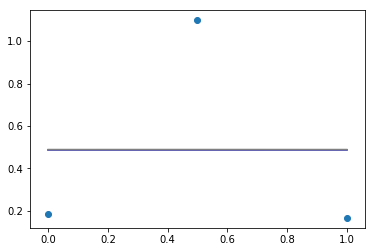

EPOCH: 751
EPOCH: 752
EPOCH: 753
EPOCH: 754
EPOCH: 755
EPOCH: 756
EPOCH: 757
EPOCH: 758
EPOCH: 759
EPOCH: 760
EPOCH: 761
EPOCH: 762
EPOCH: 763
EPOCH: 764
EPOCH: 765
EPOCH: 766
EPOCH: 767
EPOCH: 768
EPOCH: 769
EPOCH: 770
EPOCH: 771
EPOCH: 772
EPOCH: 773
EPOCH: 774
EPOCH: 775
EPOCH: 776
EPOCH: 777
EPOCH: 778
EPOCH: 779
EPOCH: 780
EPOCH: 781
EPOCH: 782
EPOCH: 783
EPOCH: 784
EPOCH: 785
EPOCH: 786
EPOCH: 787
EPOCH: 788
EPOCH: 789
EPOCH: 790
EPOCH: 791
EPOCH: 792
EPOCH: 793
EPOCH: 794
EPOCH: 795
EPOCH: 796
EPOCH: 797
EPOCH: 798
EPOCH: 799
EPOCH: 800
EPOCH 800, LOSS tensor([74.0728], grad_fn=<SubBackward0>)


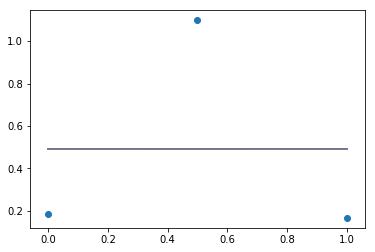

EPOCH: 801
EPOCH: 802
EPOCH: 803
EPOCH: 804
EPOCH: 805
EPOCH: 806
EPOCH: 807
EPOCH: 808
EPOCH: 809
EPOCH: 810
EPOCH: 811
EPOCH: 812
EPOCH: 813
EPOCH: 814
EPOCH: 815
EPOCH: 816
EPOCH: 817
EPOCH: 818
EPOCH: 819
EPOCH: 820
EPOCH: 821
EPOCH: 822
EPOCH: 823
EPOCH: 824
EPOCH: 825
EPOCH: 826
EPOCH: 827
EPOCH: 828
EPOCH: 829
EPOCH: 830
EPOCH: 831
EPOCH: 832
EPOCH: 833
EPOCH: 834
EPOCH: 835
EPOCH: 836
EPOCH: 837
EPOCH: 838
EPOCH: 839
EPOCH: 840
EPOCH: 841
EPOCH: 842
EPOCH: 843
EPOCH: 844
EPOCH: 845
EPOCH: 846
EPOCH: 847
EPOCH: 848
EPOCH: 849
EPOCH: 850
EPOCH 850, LOSS tensor([74.0714], grad_fn=<SubBackward0>)


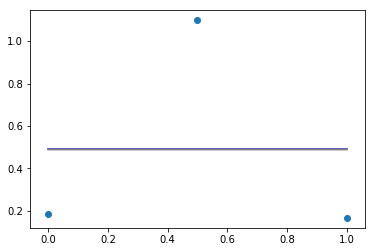

EPOCH: 851
EPOCH: 852
EPOCH: 853
EPOCH: 854
EPOCH: 855
EPOCH: 856
EPOCH: 857
EPOCH: 858
EPOCH: 859
EPOCH: 860
EPOCH: 861
EPOCH: 862
EPOCH: 863
EPOCH: 864
EPOCH: 865
EPOCH: 866
EPOCH: 867
EPOCH: 868
EPOCH: 869
EPOCH: 870
EPOCH: 871
EPOCH: 872
EPOCH: 873
EPOCH: 874
EPOCH: 875
EPOCH: 876
EPOCH: 877
EPOCH: 878
EPOCH: 879
EPOCH: 880
EPOCH: 881
EPOCH: 882
EPOCH: 883
EPOCH: 884
EPOCH: 885
EPOCH: 886
EPOCH: 887
EPOCH: 888
EPOCH: 889
EPOCH: 890
EPOCH: 891
EPOCH: 892
EPOCH: 893
EPOCH: 894
EPOCH: 895
EPOCH: 896
EPOCH: 897
EPOCH: 898
EPOCH: 899
EPOCH: 900
EPOCH 900, LOSS tensor([74.0716], grad_fn=<SubBackward0>)


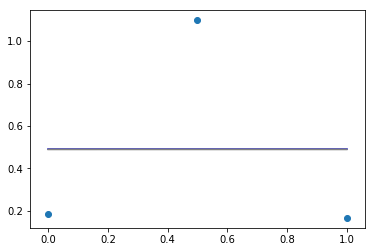

EPOCH: 901
EPOCH: 902
EPOCH: 903
EPOCH: 904
EPOCH: 905
EPOCH: 906
EPOCH: 907
EPOCH: 908
EPOCH: 909
EPOCH: 910
EPOCH: 911
EPOCH: 912
EPOCH: 913
EPOCH: 914
EPOCH: 915
EPOCH: 916
EPOCH: 917
EPOCH: 918
EPOCH: 919
EPOCH: 920
EPOCH: 921
EPOCH: 922
EPOCH: 923
EPOCH: 924
EPOCH: 925
EPOCH: 926
EPOCH: 927
EPOCH: 928
EPOCH: 929
EPOCH: 930
EPOCH: 931
EPOCH: 932
EPOCH: 933
EPOCH: 934
EPOCH: 935
EPOCH: 936
EPOCH: 937
EPOCH: 938
EPOCH: 939
EPOCH: 940
EPOCH: 941
EPOCH: 942
EPOCH: 943
EPOCH: 944
EPOCH: 945
EPOCH: 946
EPOCH: 947
EPOCH: 948
EPOCH: 949
EPOCH: 950
EPOCH 950, LOSS tensor([74.0734], grad_fn=<SubBackward0>)


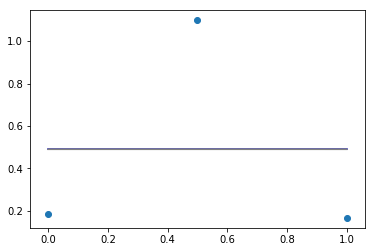

EPOCH: 951
EPOCH: 952
EPOCH: 953
EPOCH: 954
EPOCH: 955
EPOCH: 956
EPOCH: 957
EPOCH: 958
EPOCH: 959
EPOCH: 960
EPOCH: 961
EPOCH: 962
EPOCH: 963
EPOCH: 964
EPOCH: 965
EPOCH: 966
EPOCH: 967
EPOCH: 968
EPOCH: 969
EPOCH: 970
EPOCH: 971
EPOCH: 972
EPOCH: 973
EPOCH: 974
EPOCH: 975
EPOCH: 976
EPOCH: 977
EPOCH: 978
EPOCH: 979
EPOCH: 980
EPOCH: 981
EPOCH: 982
EPOCH: 983
EPOCH: 984
EPOCH: 985
EPOCH: 986
EPOCH: 987
EPOCH: 988
EPOCH: 989
EPOCH: 990
EPOCH: 991
EPOCH: 992
EPOCH: 993
EPOCH: 994
EPOCH: 995
EPOCH: 996
EPOCH: 997
EPOCH: 998
EPOCH: 999
EPOCH: 1000
EPOCH 1000, LOSS tensor([74.0730], grad_fn=<SubBackward0>)


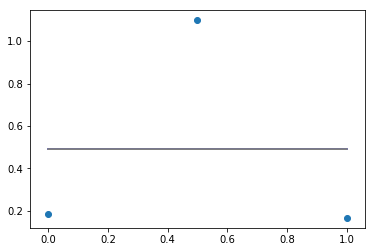

EPOCH: 1001
EPOCH: 1002
EPOCH: 1003
EPOCH: 1004
EPOCH: 1005
EPOCH: 1006
EPOCH: 1007
EPOCH: 1008
EPOCH: 1009
EPOCH: 1010
EPOCH: 1011
EPOCH: 1012
EPOCH: 1013
EPOCH: 1014
EPOCH: 1015
EPOCH: 1016
EPOCH: 1017
EPOCH: 1018
EPOCH: 1019
EPOCH: 1020
EPOCH: 1021
EPOCH: 1022
EPOCH: 1023
EPOCH: 1024
EPOCH: 1025
EPOCH: 1026
EPOCH: 1027
EPOCH: 1028
EPOCH: 1029
EPOCH: 1030
EPOCH: 1031
EPOCH: 1032
EPOCH: 1033
EPOCH: 1034
EPOCH: 1035
EPOCH: 1036
EPOCH: 1037
EPOCH: 1038
EPOCH: 1039
EPOCH: 1040
EPOCH: 1041
EPOCH: 1042
EPOCH: 1043
EPOCH: 1044
EPOCH: 1045
EPOCH: 1046
EPOCH: 1047
EPOCH: 1048
EPOCH: 1049
EPOCH: 1050
EPOCH 1050, LOSS tensor([74.0724], grad_fn=<SubBackward0>)


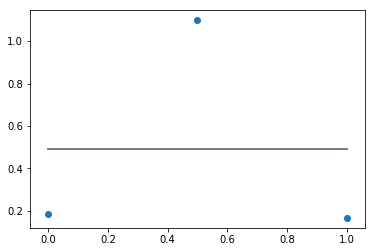

EPOCH: 1051
EPOCH: 1052
EPOCH: 1053
EPOCH: 1054
EPOCH: 1055
EPOCH: 1056
EPOCH: 1057
EPOCH: 1058
EPOCH: 1059
EPOCH: 1060
EPOCH: 1061
EPOCH: 1062
EPOCH: 1063
EPOCH: 1064
EPOCH: 1065
EPOCH: 1066
EPOCH: 1067
EPOCH: 1068
EPOCH: 1069
EPOCH: 1070
EPOCH: 1071
EPOCH: 1072
EPOCH: 1073
EPOCH: 1074
EPOCH: 1075
EPOCH: 1076
EPOCH: 1077
EPOCH: 1078
EPOCH: 1079
EPOCH: 1080
EPOCH: 1081
EPOCH: 1082
EPOCH: 1083
EPOCH: 1084
EPOCH: 1085
EPOCH: 1086
EPOCH: 1087
EPOCH: 1088
EPOCH: 1089
EPOCH: 1090
EPOCH: 1091
EPOCH: 1092
EPOCH: 1093
EPOCH: 1094
EPOCH: 1095
EPOCH: 1096
EPOCH: 1097
EPOCH: 1098
EPOCH: 1099
EPOCH: 1100
EPOCH 1100, LOSS tensor([74.0728], grad_fn=<SubBackward0>)


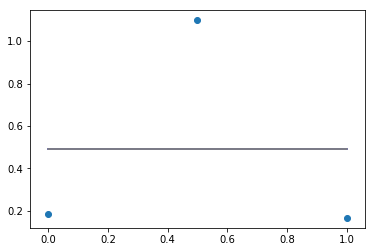

EPOCH: 1101
EPOCH: 1102
EPOCH: 1103
EPOCH: 1104
EPOCH: 1105
EPOCH: 1106
EPOCH: 1107
EPOCH: 1108
EPOCH: 1109
EPOCH: 1110
EPOCH: 1111
EPOCH: 1112
EPOCH: 1113
EPOCH: 1114
EPOCH: 1115
EPOCH: 1116
EPOCH: 1117
EPOCH: 1118
EPOCH: 1119
EPOCH: 1120
EPOCH: 1121
EPOCH: 1122
EPOCH: 1123
EPOCH: 1124
EPOCH: 1125
EPOCH: 1126
EPOCH: 1127
EPOCH: 1128
EPOCH: 1129
EPOCH: 1130
EPOCH: 1131
EPOCH: 1132
EPOCH: 1133
EPOCH: 1134
EPOCH: 1135
EPOCH: 1136
EPOCH: 1137
EPOCH: 1138
EPOCH: 1139
EPOCH: 1140
EPOCH: 1141
EPOCH: 1142
EPOCH: 1143
EPOCH: 1144
EPOCH: 1145
EPOCH: 1146
EPOCH: 1147
EPOCH: 1148
EPOCH: 1149
EPOCH: 1150
EPOCH 1150, LOSS tensor([74.0708], grad_fn=<SubBackward0>)


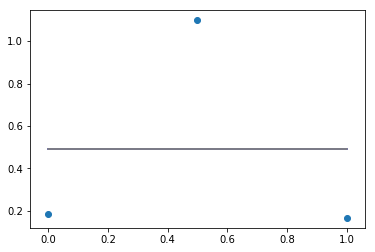

EPOCH: 1151
EPOCH: 1152
EPOCH: 1153
EPOCH: 1154
EPOCH: 1155
EPOCH: 1156
EPOCH: 1157
EPOCH: 1158
EPOCH: 1159
EPOCH: 1160
EPOCH: 1161
EPOCH: 1162
EPOCH: 1163
EPOCH: 1164
EPOCH: 1165
EPOCH: 1166
EPOCH: 1167
EPOCH: 1168
EPOCH: 1169
EPOCH: 1170
EPOCH: 1171
EPOCH: 1172
EPOCH: 1173
EPOCH: 1174
EPOCH: 1175
EPOCH: 1176
EPOCH: 1177
EPOCH: 1178
EPOCH: 1179
EPOCH: 1180
EPOCH: 1181
EPOCH: 1182
EPOCH: 1183
EPOCH: 1184
EPOCH: 1185
EPOCH: 1186
EPOCH: 1187
EPOCH: 1188
EPOCH: 1189
EPOCH: 1190
EPOCH: 1191
EPOCH: 1192
EPOCH: 1193
EPOCH: 1194
EPOCH: 1195
EPOCH: 1196
EPOCH: 1197
EPOCH: 1198
EPOCH: 1199
EPOCH: 1200
EPOCH 1200, LOSS tensor([74.0679], grad_fn=<SubBackward0>)


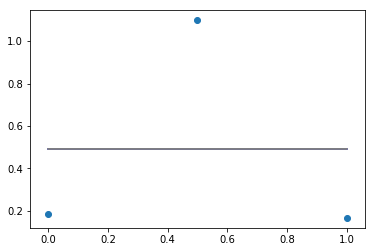

EPOCH: 1201
EPOCH: 1202
EPOCH: 1203
EPOCH: 1204
EPOCH: 1205
EPOCH: 1206
EPOCH: 1207
EPOCH: 1208
EPOCH: 1209
EPOCH: 1210
EPOCH: 1211
EPOCH: 1212
EPOCH: 1213
EPOCH: 1214
EPOCH: 1215
EPOCH: 1216
EPOCH: 1217
EPOCH: 1218
EPOCH: 1219
EPOCH: 1220
EPOCH: 1221
EPOCH: 1222
EPOCH: 1223
EPOCH: 1224
EPOCH: 1225
EPOCH: 1226
EPOCH: 1227
EPOCH: 1228
EPOCH: 1229
EPOCH: 1230
EPOCH: 1231
EPOCH: 1232
EPOCH: 1233
EPOCH: 1234
EPOCH: 1235
EPOCH: 1236
EPOCH: 1237
EPOCH: 1238
EPOCH: 1239
EPOCH: 1240
EPOCH: 1241
EPOCH: 1242
EPOCH: 1243
EPOCH: 1244
EPOCH: 1245
EPOCH: 1246
EPOCH: 1247
EPOCH: 1248
EPOCH: 1249
EPOCH: 1250
EPOCH 1250, LOSS tensor([74.0694], grad_fn=<SubBackward0>)


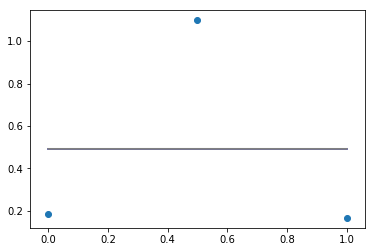

EPOCH: 1251
EPOCH: 1252
EPOCH: 1253
EPOCH: 1254
EPOCH: 1255
EPOCH: 1256
EPOCH: 1257
EPOCH: 1258
EPOCH: 1259
EPOCH: 1260
EPOCH: 1261
EPOCH: 1262
EPOCH: 1263
EPOCH: 1264
EPOCH: 1265
EPOCH: 1266
EPOCH: 1267
EPOCH: 1268
EPOCH: 1269
EPOCH: 1270
EPOCH: 1271
EPOCH: 1272
EPOCH: 1273
EPOCH: 1274
EPOCH: 1275
EPOCH: 1276
EPOCH: 1277
EPOCH: 1278
EPOCH: 1279
EPOCH: 1280
EPOCH: 1281
EPOCH: 1282
EPOCH: 1283
EPOCH: 1284
EPOCH: 1285
EPOCH: 1286
EPOCH: 1287
EPOCH: 1288
EPOCH: 1289
EPOCH: 1290
EPOCH: 1291
EPOCH: 1292
EPOCH: 1293
EPOCH: 1294
EPOCH: 1295
EPOCH: 1296
EPOCH: 1297
EPOCH: 1298
EPOCH: 1299
EPOCH: 1300
EPOCH 1300, LOSS tensor([74.0664], grad_fn=<SubBackward0>)


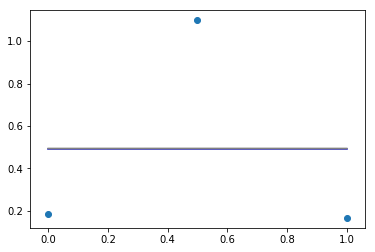

EPOCH: 1301
EPOCH: 1302
EPOCH: 1303
EPOCH: 1304
EPOCH: 1305
EPOCH: 1306
EPOCH: 1307
EPOCH: 1308
EPOCH: 1309
EPOCH: 1310
EPOCH: 1311
EPOCH: 1312
EPOCH: 1313
EPOCH: 1314
EPOCH: 1315
EPOCH: 1316
EPOCH: 1317
EPOCH: 1318
EPOCH: 1319
EPOCH: 1320
EPOCH: 1321
EPOCH: 1322
EPOCH: 1323
EPOCH: 1324
EPOCH: 1325
EPOCH: 1326
EPOCH: 1327
EPOCH: 1328
EPOCH: 1329
EPOCH: 1330
EPOCH: 1331
EPOCH: 1332
EPOCH: 1333
EPOCH: 1334
EPOCH: 1335
EPOCH: 1336
EPOCH: 1337
EPOCH: 1338
EPOCH: 1339
EPOCH: 1340
EPOCH: 1341
EPOCH: 1342
EPOCH: 1343
EPOCH: 1344
EPOCH: 1345
EPOCH: 1346
EPOCH: 1347
EPOCH: 1348
EPOCH: 1349
EPOCH: 1350
EPOCH 1350, LOSS tensor([74.0675], grad_fn=<SubBackward0>)


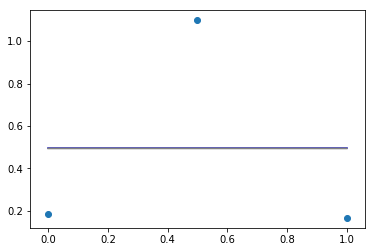

EPOCH: 1351


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [128]:
train_infoVAE(model, 10000, 1, 1, optimizer)